In [ ]:
# Copyright 2025 Bytedance Ltd. and/or its affiliates.
# SPDX-License-Identifier: Apache-2.0

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from copy import deepcopy
from typing import (
    Any,
    AsyncIterable,
    Callable,
    Dict,
    Generator,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union,
)
import requests
from io import BytesIO

from PIL import Image
import torch
from accelerate import infer_auto_device_map, load_checkpoint_and_dispatch, init_empty_weights

from data.transforms import ImageTransform
from data.data_utils import pil_img2rgb, add_special_tokens
from modeling.bagel import (
    BagelConfig, Bagel, Qwen2Config, Qwen2ForCausalLM, SiglipVisionConfig, SiglipVisionModel
)
from modeling.qwen2 import Qwen2Tokenizer
from modeling.bagel.qwen2_navit import NaiveCache
from modeling.autoencoder import load_ae
from safetensors.torch import load_file

## Model Initialization

In [3]:
# model_path = "/path/to/BAGEL-7B-MoT/weights"  # Download from https://huggingface.co/ByteDance-Seed/BAGEL-7B-MoT
model_path = "./models/Bagel-Zebra-CoT/"  # Download from https://huggingface.co/ByteDance-Seed/BAGEL-7B-MoT

# LLM config preparing
llm_config = Qwen2Config.from_json_file(os.path.join(model_path, "llm_config.json"))
llm_config.qk_norm = True
llm_config.tie_word_embeddings = False
llm_config.layer_module = "Qwen2MoTDecoderLayer"

# ViT config preparing
vit_config = SiglipVisionConfig.from_json_file(os.path.join(model_path, "vit_config.json"))
vit_config.rope = False
vit_config.num_hidden_layers = vit_config.num_hidden_layers - 1

# VAE loading
vae_model, vae_config = load_ae(local_path=os.path.join(model_path, "ae.safetensors"))

# Bagel config preparing
config = BagelConfig(
    visual_gen=True,
    visual_und=True,
    llm_config=llm_config, 
    vit_config=vit_config,
    vae_config=vae_config,
    vit_max_num_patch_per_side=70,
    connector_act='gelu_pytorch_tanh',
    latent_patch_size=2,
    max_latent_size=64,
)

with init_empty_weights():
    language_model = Qwen2ForCausalLM(llm_config)
    vit_model      = SiglipVisionModel(vit_config)
    model          = Bagel(language_model, vit_model, config)
    model.vit_model.vision_model.embeddings.convert_conv2d_to_linear(vit_config, meta=True)

# Tokenizer Preparing
tokenizer = Qwen2Tokenizer.from_pretrained(model_path)
tokenizer, new_token_ids, _ = add_special_tokens(tokenizer)

# Image Transform Preparing
vae_transform = ImageTransform(1024, 512, 16)
vit_transform = ImageTransform(980, 224, 14)

## Model Loading and Multi GPU Infernece Preparing

In [4]:
max_mem_per_gpu = "80GiB"  # Modify it according to your GPU setting. On an A100, 80 GiB is sufficient to load on a single GPU.

device_map = infer_auto_device_map(
    model,
    max_memory={i: max_mem_per_gpu for i in range(torch.cuda.device_count())},
    no_split_module_classes=["Bagel", "Qwen2MoTDecoderLayer"],
)
print(device_map)

same_device_modules = [
    'language_model.model.embed_tokens',
    'time_embedder',
    'latent_pos_embed',
    'vae2llm',
    'llm2vae',
    'connector',
    'vit_pos_embed'
]

if torch.cuda.device_count() == 1:
    first_device = device_map.get(same_device_modules[0], "cuda:0")
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device
        else:
            device_map[k] = "cuda:0"
else:
    first_device = device_map.get(same_device_modules[0])
    for k in same_device_modules:
        if k in device_map:
            device_map[k] = first_device

# Thanks @onion-liu: https://github.com/ByteDance-Seed/Bagel/pull/8
model = load_checkpoint_and_dispatch(
    model,
    checkpoint=os.path.join(model_path, "ema.safetensors"),
    device_map=device_map,
    offload_buffers=True,
    dtype=torch.bfloat16,
    force_hooks=True,
    offload_folder="/tmp/offload"
)

model = model.eval()
print('Model loaded')

The safetensors archive passed at ./models/Bagel-Zebra-CoT/ema.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


OrderedDict([('', 0)])
Model loaded


## Inferencer Preparing 

In [5]:
from inferencer import InterleaveInferencer

inferencer = InterleaveInferencer(
    model=model, 
    vae_model=vae_model, 
    tokenizer=tokenizer, 
    vae_transform=vae_transform, 
    vit_transform=vit_transform, 
    new_token_ids=new_token_ids
)

In [6]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**About Inference Hyperparameters:**
- **`cfg_text_scale`:** Controls how strongly the model follows the text prompt. `1.0` disables text guidance. Typical range: `4.0–8.0`.
- **`cfg_image_scale`:** Controls how much the model preserves input image details. `1.0` disables image guidance. Typical range: `1.0–2.0`.
- **`cfg_interval`:** Fraction of denoising steps where CFG is applied. Later steps can skip CFG to reduce computation. Typical: `[0.4, 1.0]`.
- **`timestep_shift`:** Shifts the distribution of denoising steps. Higher values allocate more steps at the start (affects layout); lower values allocate more at the end (improves details).
- **`num_timesteps`:** Total denoising steps. Typical: `50`.
- **`cfg_renorm_min`:** Minimum value for CFG-Renorm. `1.0` disables renorm. Typical: `0`.
- **`cfg_renorm_type`:** CFG-Renorm method:  
  - `global`: Normalize over all tokens and channels (default for T2I).
  - `channel`: Normalize across channels for each token.
  - `text_channel`: Like `channel`, but only applies to text condition (good for editing, may cause blur).
- **If edited images appear blurry, try `global` CFG-Renorm, decrease `cfg_renorm_min` or decrease `cfg_scale`.**


## Image Generation

In [7]:
inference_hyper=dict(
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere.
----------


100%|███████████████████████████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.09it/s]


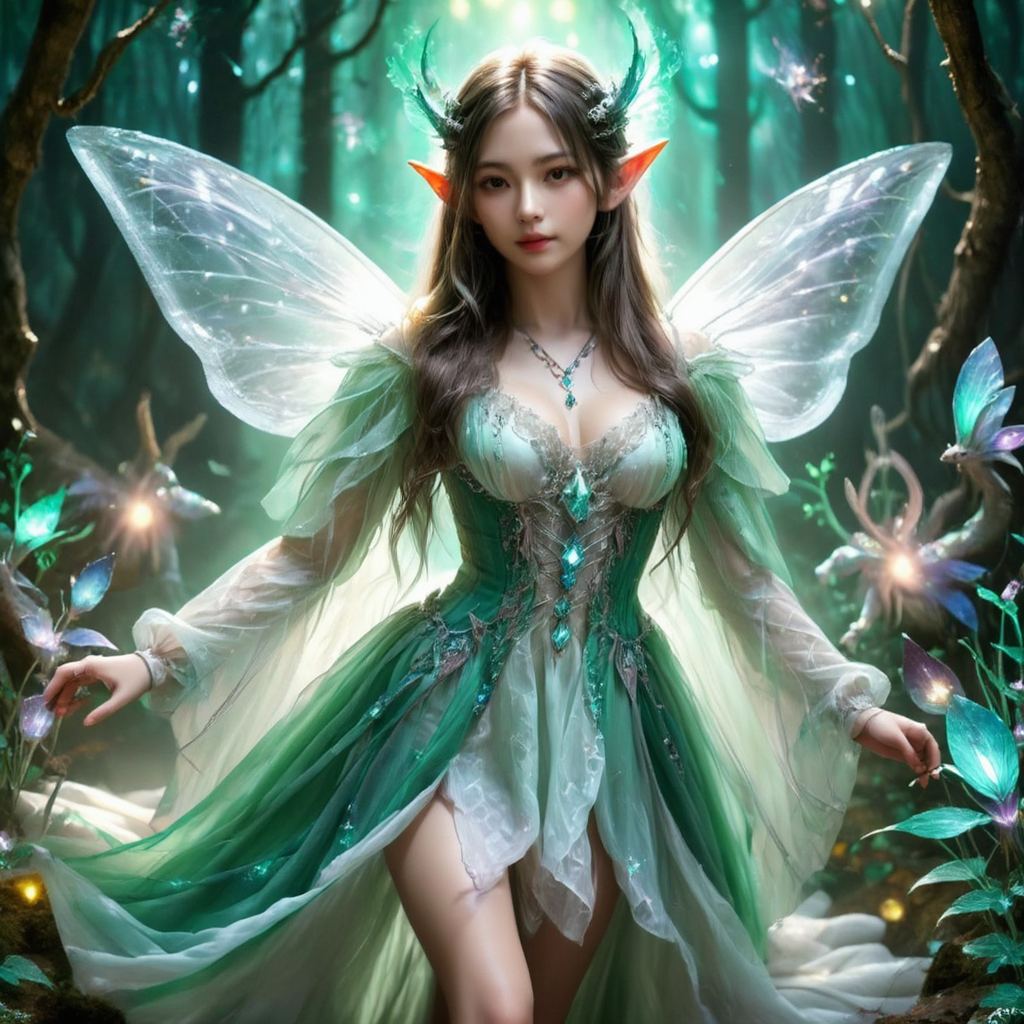

In [8]:
prompt = "A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere."

print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, **inference_hyper)
display(output_dict['image'])

## Image Generation with Think

In [ ]:
inference_hyper=dict(
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=1.0,
    cfg_interval=[0.4, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="global",
)

In [ ]:
prompt = 'a car made of small cars'

print(prompt)
print('-' * 10)
output_dict = inferencer(text=prompt, think=True, **inference_hyper)
print(output_dict['text'])
display(output_dict['image'])

## Editing

In [ ]:
inference_hyper=dict(
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

In [ ]:
image = Image.open('test_images/women.jpg')
prompt = 'She boards a modern subway, quietly reading a folded newspaper, wearing the same clothes.'

display(image)
print(prompt)
print('-'*10)
output_dict = inferencer(image=image, text=prompt, **inference_hyper)
display(output_dict['image'])

## Edit with Think

In [ ]:
inference_hyper=dict(
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
    cfg_text_scale=4.0,
    cfg_img_scale=2.0,
    cfg_interval=[0.0, 1.0],
    timestep_shift=3.0,
    num_timesteps=50,
    cfg_renorm_min=0.0,
    cfg_renorm_type="text_channel",
)

In [ ]:
image = Image.open('test_images/octupusy.jpg')
prompt = 'Could you display the sculpture that takes after this design?'

display(image)
print('-'*10)
output_dict = inferencer(image=image, text=prompt, think=True, **inference_hyper)
print(output_dict['text'])
display(output_dict['image'])

## Understanding

In [ ]:
inference_hyper=dict(
    max_think_token_n=1000,
    do_sample=False,
    # text_temperature=0.3,
)

In [ ]:
image = Image.open('test_images/meme.jpg')
prompt = "Can someone explain what’s funny about this meme??"

display(image)
print(prompt)
print('-'*10)
output_dict = inferencer(image=image, text=prompt, understanding_output=True, **inference_hyper)
print(output_dict['text'])